# Comparison of regression models in predicting next-day stock returns

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date, datetime, timedelta
import os
from newsapi.newsapi_client import NewsApiClient
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import hvplot.pandas
from joblib import dump, load

In [3]:
# Set News API Key
newsapi = NewsApiClient(api_key=os.getenv("NEWS_API_KEY"))

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY_ID")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [53]:
# TODO
# Selecting the tickers can be a stand-alone function
# Set the ticker
tickers = ["AAPL", "AMZN", "GOOGL", "NFLX"]

# Set timeframe to '1D'
timeframe = '1D'

# Get current date and the date from one month ago
current_date = date.today()
past_date = date.today() - timedelta(weeks=4)

df = pd.DataFrame()

# Get historical data for AAPL
for tick in tickers:
    tmp_df = api.get_barset(
        tick,
        timeframe,
        limit=1000,
        start=current_date,
        end=past_date,
        after=None,
        until=None,
    ).df
    tmp_df = tmp_df.droplevel(0, axis=1)
    tmp_df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
    tmp_df.rename({'close': tick}, axis=1, inplace=True)
    df = pd.concat([df, tmp_df], axis=1)
    
df.index = df.index.date

# df.head()
len(df)

1000

In [54]:
print(df.head())
print(df.tail())

             AAPL    AMZN   GOOGL     NFLX
2016-07-12  97.42  748.21  732.50  95.9700
2016-07-13  96.87  742.74  729.47  96.4300
2016-07-14  98.79  741.19  735.78  98.0200
2016-07-15  98.76  735.43  735.64  98.3900
2016-07-18  99.83  736.07  753.42  98.8037
              AAPL     AMZN    GOOGL    NFLX
2020-06-24  360.06  2733.49  1432.17  457.65
2020-06-25  364.88  2756.16  1441.15  466.14
2020-06-26  353.69  2692.87  1362.14  443.39
2020-06-29  362.00  2681.52  1398.00  447.42
2020-06-30  364.60  2756.09  1417.92  454.75


## AAPL

### Create AAPL df

In [62]:
aapl_df = df['AAPL'].to_frame()
aapl_df.index = pd.to_datetime(aapl_df.index)
aapl_df.rename(columns={'AAPL': 'close'}, inplace=True)
aapl_df.dropna(inplace=True)

In [63]:
aapl_df.head()

,close
2016-07-12,97.42
2016-07-13,96.87
2016-07-14,98.79
2016-07-15,98.76
2016-07-18,99.83


In [64]:
# Return
aapl_df["return"] = aapl_df["close"].pct_change()

# Exponentially weighted moving average
aapl_df["short_window_ma"] = aapl_df["close"].ewm(halflife=short_window_aapl).mean()
aapl_df["long_window_ma"] = aapl_df["close"].ewm(halflife=long_window_aapl).mean()

# Expoentially weighted volatility
aapl_df["fast_vol"] = aapl_df["return"].ewm(halflife=short_window_aapl).std()
aapl_df["slow_vol"] = aapl_df["return"].ewm(halflife=long_window_aapl).std()

aapl_df.dropna(inplace=True)
aapl_df.drop(columns=['return'], inplace=True)

In [65]:
aapl_df.tail()

,close,short_window_ma,long_window_ma,fast_vol,slow_vol
2020-06-24,360.06,317.329785,265.882957,0.025179,0.026810
2020-06-25,364.88,318.949520,266.567462,0.024794,0.026732
2020-06-26,353.69,320.132908,267.169858,0.025240,0.026783
2020-06-29,362.00,321.559055,267.825542,0.025060,0.026747
2020-06-30,364.60,323.025188,268.494666,0.024634,0.026657


### Prep data for model fitting

In [77]:
def window_data(df, window, feature_col_nums, target_col_num):
    X = []
    y = []
    
    for i in range(len(df) - window + 1):
        X_comp = df.iloc[i:(i+window), feature_col_nums]
        y_comp = df.iloc[window, target_col_num]
        X.append(X_comp.to_numpy())
        y.append(y_comp)
    return X, np.array(y).reshape(-1, 1)

short_window_aapl = 20
long_window_aapl = 100

X_aapl, y_aapl = window_data(aapl_df, short_window_aapl, [1, 2, 3, 4], 0)

In [84]:
from sklearn.preprocessing import MinMaxScaler

scaler_aapl = MinMaxScaler()

In [91]:
# Since X is a list of arrays, need to call scaler on each sub array individually
for sub_array in X_aapl:
    scaler_aapl.fit(sub_array)

X_aapl_scaled = [scaler_aapl.transform(sub_array) for sub_array in X_aapl]

y_aapl_scaled = scaler_aapl.fit_transform(y_aapl)

In [92]:
# Train/test split
test_size = 0.30
split = int(len(X_aapl) * (1 - test_size))

X_train_aapl = X_aapl[:split]
X_test_aapl = X_aapl[split:]

y_train_aapl = y_aapl[:split]
y_test_aapl = y_aapl[split:]

### AAPL with SVR

In [238]:
from sklearn.svm import SVR

svr_aapl = SVR()

In [239]:
svr_aapl.fit(X_train_aapl_scaled, y_train_aapl)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [240]:
SVR_predictions_aapl = svr_aapl.predict(X_test_aapl_scaled)

SVR_predictions_aapl_df = pd.DataFrame({'predictions': SVR_predictions_aapl, 'actual': np.ravel(y_test_aapl)})

In [241]:
SVR_predictions_aapl_df.head()

,predictions,actual
0,-0.012339,0.009608
1,-0.012339,-0.008170
2,-0.012339,-0.014754
3,-0.012339,0.004548
4,-0.012339,-0.004573


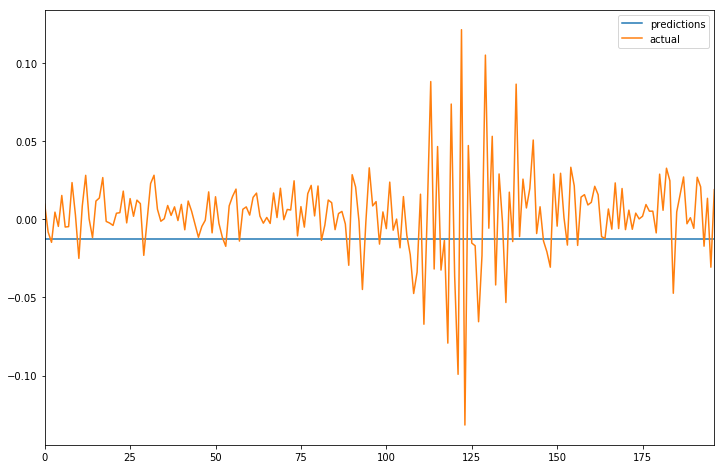

In [242]:
SVR_predictions_aapl_df.plot(figsize=(12,8))

In [243]:
from sklearn.metrics import mean_squared_error

SVR_MSE_aapl = mean_squared_error(y_test_aapl, SVR_predictions_aapl)

print(f"SVR MSE: {SVR_MSE_aapl}")

SVR MSE: 0.000993018005856526


### AAPL with Random Forest

In [244]:
from sklearn.ensemble import RandomForestRegressor

rfr_aapl = RandomForestRegressor(max_depth=2, random_state=0)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


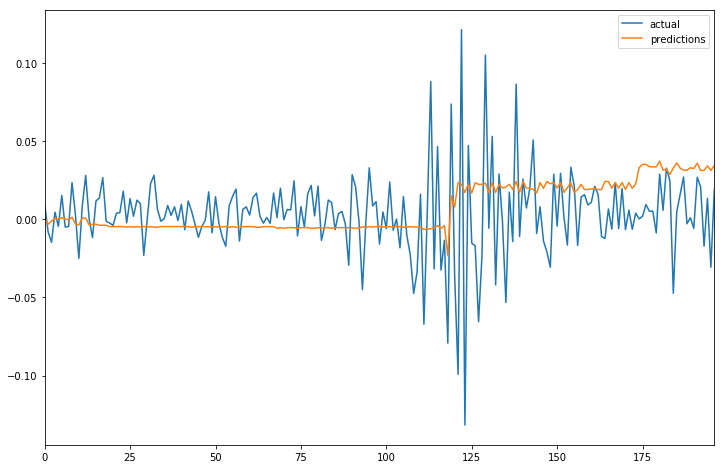

In [245]:
rfr_aapl.fit(X_train_aapl_scaled, y_train_aapl)

RF_predictions_aapl = rfr_aapl.predict(X_test_aapl_scaled)

RF_predictions_aapl_df = pd.DataFrame({'actual': np.ravel(y_test_aapl), 'predictions': RF_predictions_aapl})

RF_predictions_aapl_df.plot(figsize=(12,8))

In [246]:
RF_MSE_aapl = mean_squared_error(y_test_aapl, RF_predictions_aapl)

print(f"SVR MSE: {SVR_MSE_aapl}\nRF_MSE: {RF_MSE_aapl}")

SVR MSE: 0.000993018005856526
RF_MSE: 0.0009173435635567752


### AAPL with Gradient Boosting Regressor

In [247]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_aapl = GradientBoostingRegressor(random_state=0)

In [248]:
gbr_aapl.fit(X_train_aapl_scaled, y_train_aapl)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

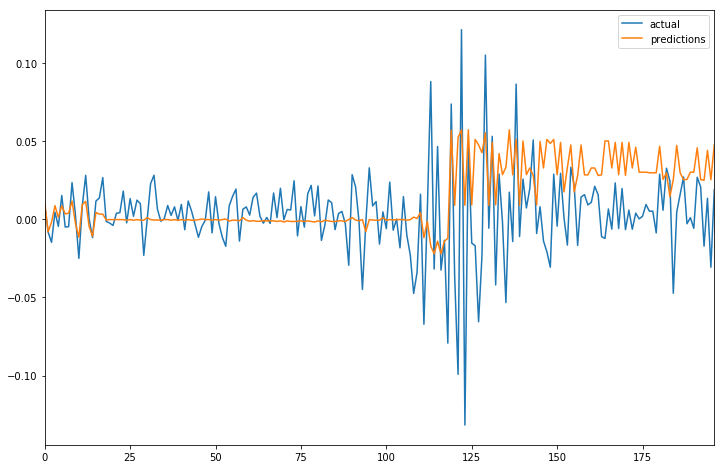

In [249]:
GBR_predictions_aapl = gbr_aapl.predict(X_test_aapl_scaled)

GBR_predictions_aapl_df = pd.DataFrame({'actual': np.ravel(y_test_aapl), 'predictions': GBR_predictions_aapl})

GBR_predictions_aapl_df.plot(figsize=(12,8))

In [250]:
GBR_MSE_aapl = mean_squared_error(y_test_aapl, GBR_predictions_aapl)

print(f"GBR MSE: {GBR_MSE_aapl}\nRF_MSE: {RF_MSE_aapl}\nSVR_MSE: {SVR_MSE_aapl}")

GBR MSE: 0.001031021592353897
RF_MSE: 0.0009173435635567752
SVR_MSE: 0.000993018005856526


## AMZN

### Prep data for model fitting

In [251]:
amzn_df = df.loc[:, 'AMZN'].to_frame()
amzn_df.index = pd.to_datetime(amzn_df.index)
amzn_df.rename(columns={'AMZN': 'close'}, inplace=True)
amzn_df['lag_1_day'] = amzn_df['close'].shift()
amzn_df.dropna(inplace=True)

In [252]:
amzn_df.head()

,close,lag_1_day
2016-07-12,748.21,753.78
2016-07-13,742.74,748.21
2016-07-14,741.19,742.74
2016-07-15,735.43,741.19
2016-07-18,736.07,735.43


In [253]:
amzn_df["return"] = amzn_df["close"].pct_change()
amzn_df["lag_return"] = amzn_df["lag_1_day"].pct_change()
amzn_df.dropna(inplace=True)

In [254]:
amzn_df.head()

,close,lag_1_day,return,lag_return
2016-07-13,742.74,748.21,-0.007311,-0.007389
2016-07-14,741.19,742.74,-0.002087,-0.007311
2016-07-15,735.43,741.19,-0.007771,-0.002087
2016-07-18,736.07,735.43,0.000870,-0.007771
2016-07-19,740.06,736.07,0.005421,0.000870


In [255]:
short_window_amzn = 20
long_window_amzn = 100

# Exponentially weighted moving average
amzn_df["short_window_ma"] = amzn_df["close"].ewm(halflife=short_window_amzn).mean()
amzn_df["long_window_ma"] = amzn_df["close"].ewm(halflife=long_window_amzn).mean()

# Expoentially weighted volatility
amzn_df["fast_vol"] = amzn_df["return"].ewm(halflife=short_window_amzn).std()
amzn_df["slow_vol"] = amzn_df["return"].ewm(halflife=long_window_amzn).std()

In [256]:
amzn_df.dropna(inplace=True)

In [257]:
amzn_df.head()

,close,lag_1_day,return,lag_return,short_window_ma,long_window_ma,fast_vol,slow_vol
2016-07-14,741.19,742.74,-0.002087,-0.007311,741.951572,741.962314,0.003694,0.003694
2016-07-15,735.43,741.19,-0.007771,-0.002087,739.701954,739.769766,0.003162,0.003158
2016-07-18,736.07,735.43,0.000870,-0.007771,738.746232,738.835185,0.004221,0.004192
2016-07-19,740.06,736.07,0.005421,0.000870,739.027506,739.083556,0.005637,0.005594
2016-07-20,745.72,740.06,0.007648,0.005421,740.241748,740.208885,0.006442,0.006413


In [258]:
# Choose target
X_amzn = amzn_df.drop(columns=['return'])
y_amzn = amzn_df['return'].values.reshape(-1, 1)

In [259]:
from sklearn.model_selection import train_test_split

X_train_amzn, X_test_amzn, y_train_amzn, y_test_amzn = train_test_split(X_amzn, y_amzn, random_state=0, test_size=0.20)

In [260]:
from sklearn.preprocessing import StandardScaler

scaler_amzn = StandardScaler()

In [261]:
X_train_amzn_scaled, X_test_amzn_scaled = scaler_amzn.fit_transform(X_train_amzn), scaler_amzn.transform(X_test_amzn)

### AMZN with Gradient Boosting Regressor

In [262]:
gbr_amzn = GradientBoostingRegressor(random_state=0)

gbr_amzn.fit(X_train_amzn_scaled, y_train_amzn)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

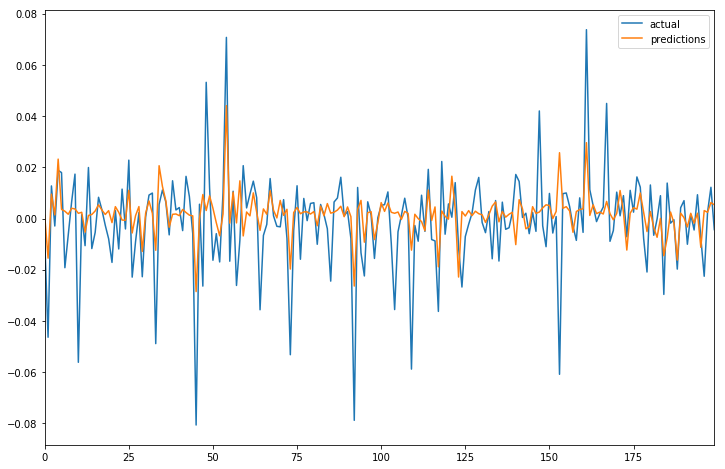

In [263]:
GBR_predictions_amzn = gbr_amzn.predict(X_test_amzn_scaled)

GBR_predictions_amzn_df = pd.DataFrame({'actual': np.ravel(y_test_amzn), 'predictions': GBR_predictions_amzn})

GBR_predictions_amzn_df.plot(figsize=(12,8))

In [264]:
from sklearn.metrics import mean_squared_error

GBR_MSE_amzn = mean_squared_error(y_test_amzn, GBR_predictions_amzn)

print(f"GBR2_MSE: {GBR_MSE_amzn}")

GBR2_MSE: 0.00025982473191847545


### AMZN with Multi-layer Perceptron Regressor

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


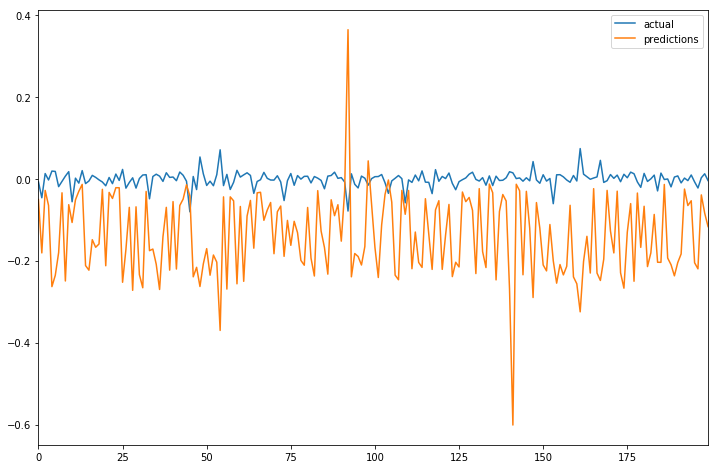

In [266]:
from sklearn.neural_network import MLPRegressor

# Fit with unscaled training data
class MLPR(MLPRegressor):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

amzn_mlpr = MLPR(random_state=0, max_iter=500, model_name="AMZN_MLPR").fit(X_train_amzn, y_train_amzn)

MLPR_predictions_amzn = amzn_mlpr.predict(X_test_amzn)

MLPR_predictions_amzn_df = pd.DataFrame(
    {'actual': np.ravel(y_test_amzn),
     'predictions': MLPR_predictions_amzn
    }
)

MLPR_predictions_amzn_df.plot(figsize=(12,8))

In [267]:
amzn_mlpr.score(X_test_amzn, y_test_amzn)

-82.34820500139942

In [268]:
X_amzn_train_2 = X_amzn.iloc[0:800]
X_amzn_test_2 = X_amzn.iloc[800:]

y_amzn_train_2 = y_amzn[0:800]
y_amzn_test_2 = y_amzn[800:]

In [275]:
mlp_amzn = MLPRegressor(random_state=0, max_iter=500).fit(X_amzn_train_2, y_amzn_train_2)

mlp_amzn.score(X_amzn_test_2, y_amzn_test_2)

/Users/peterlawson/anaconda3/envs/Viz/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-918.1915153313053

In [276]:
print(f"GBR AAPL: {gbr_aapl.score(X_test_aapl_scaled, y_test_aapl)}")
print(f"RFR AAPL: {rfr_aapl.score(X_test_aapl_scaled, y_test_aapl)}")
print(f"SVR AAPL: {svr_aapl.score(X_test_aapl_scaled, y_test_aapl)}")
print(f"SVR AAPL: {svr_aapl.score(X_test_aapl_scaled, y_test_aapl)}")
print(f"GBR AMZN: {gbr_amzn.score(X_test_amzn_scaled, y_test_amzn)}")
print(f"MLP AMZN: {mlp_amzn.score(X_test_amzn_scaled, y_test_amzn)}")

GBR AAPL: -0.35386235154935863
RFR AAPL: -0.20458865589824016
SVR AAPL: -0.303958813772645
SVR AAPL: -0.303958813772645
GBR AMZN: 0.287256209675419
MLP AMZN: -641.7629573239744


In [295]:
def get_predictions(model, data_df, days_ahead):
    ''' 
    Since we're doing time-series predictions, we need to predict individually
    the days up to the one we want. If we're predicting 30 days ahead, then
    we first need to predict the return 29 days ahead, and for 29 days
    ahead we need the return for 28 days ahead, etc.
    
    `data_df` should be a *copy* of an existing DF, since we'll be adding
    rows using predicted data, which should not be saved in the original DF.
    '''
    
    assert data != []
    
    most_recent_return = data_df.iloc[-1]
    
    if days_ahead == 0:
        return 1 + most_recent_return
    else:
        return_pred = model.predict(most_recent_return)
        
        s = pd.Series()
        
        # Currently our columns are: close, lag_1_day, lag_return, short_window_ma,
        # long_window_ma, fast_vol, slow_vol.
        # We need to add all of these as a new row to data_df so that we can run
        # the model again to predict the following day.
        s['close'] = 
        
        return 1 + pred * get_predictions(model, data, days_ahead-1)

def calc_return(closing_price_1, closing_price_2):
    '''
    Same as `Series.pct_change` but can be used generally.
    
    `closing_price_2` is assume to be the more recent price.
    '''
    return (closing_price_2 - closing_price_1) / closing_price_1

In [ ]:
most_recent = amzn_df.drop(columns=['return']).iloc[-1].values.reshape(1, -1)

# X_test_amzn.iloc[-1].values.reshape(1, -1)
get_predictions(mlp_amzn, most_recent, 10)

In [294]:
datetime.today().date() + timedelta(1)

datetime.date(2020, 6, 30)

In [352]:
amzn_df.columns

Index(['close', 'lag_1_day', 'return', 'lag_return', 'short_window_ma',
       'long_window_ma', 'fast_vol', 'slow_vol'],
      dtype='object')